In [1]:
import pandas as pd
import numpy as np
import os
import requests
import re
from shutil import copyfileobj
from urllib import request
import os
from bs4 import BeautifulSoup
from datetime import datetime


In [2]:
#ATTENTION : NE RUN QU'1 SEULE FOIS LA CELLULE
# Acquérir l'ensemble des fichiers Excel des classements via la page de classement

url = 'https://www.vendeeglobe.org/fr/classement'  #URL classement VendéeGlobe

#WEB SCRAPPING (récupérer les suffixes des noms de fichiers)
r = requests.get(url) #Requête page web
content = r.content.decode('utf-8') #Decoder contenu de la page web en string
rx = re.compile('<option value="([^<]+)">-')

date_list = [match.group(1) for match in rx.finditer(content)] #Liste des éléments récupérés par web scrapping

#Télécharger fichiers et les copier dans le dossier "data_files"
for date in date_list :
    url = f'https://www.vendeeglobe.org/download-race-data/vendeeglobe_{date}.xlsx'
    filename = f'./data_files/vendeeglobe_{date}.xlsx'
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with request.urlopen(url) as response, open(filename, 'wb') as out_file:
        copyfileobj(response, out_file)


REMARQUE : Les fichiers excel changent de format à partir de vendeeglobe_20210127_140000.xlsx

In [2]:
# FONCTION LIRE FICHIER EXCEL

import uuid
import xlwings as xw

# lecture/écriture d'un fichier Excel avec xlwings
def save_with_xlwings(file):
    tempfile = file
    excel_app = xw.App(visible=False)
    excel_book = excel_app.books.open(file)
    excel_book.save(tempfile)
    excel_book.close()
    excel_app.quit()
    return tempfile

In [4]:
# FONCTION GENERER DATE_LIST

def generate_date_list() : #WEB SCRAPPING (récupérer les suffixes des noms de fichiers)
    r = requests.get('https://www.vendeeglobe.org/fr/classement') #Requête page web
    content = r.content.decode('utf-8') #Decoder contenu de la page web en string
    rx = re.compile('<option value="([^<]+)">-')
    date_list = [match.group(1) for match in rx.finditer(content)] #Liste des éléments récupérés par web scrapping
    date_list = list(reversed(date_list))
    return date_list
generate_date_list()

['20201108_120200',
 '20201108_140000',
 '20201108_150000',
 '20201108_170000',
 '20201108_210000',
 '20201109_040000',
 '20201109_080000',
 '20201109_110000',
 '20201109_140000',
 '20201109_170000',
 '20201109_210000',
 '20201110_040000',
 '20201110_080000',
 '20201110_110000',
 '20201110_140000',
 '20201110_170000',
 '20201110_210000',
 '20201111_040000',
 '20201111_080000',
 '20201111_110000',
 '20201111_140000',
 '20201111_170000',
 '20201111_210000',
 '20201112_040000',
 '20201112_080000',
 '20201112_110000',
 '20201112_140000',
 '20201112_170000',
 '20201112_210000',
 '20201113_040000',
 '20201113_080000',
 '20201113_110000',
 '20201113_140000',
 '20201113_170000',
 '20201113_210000',
 '20201114_040000',
 '20201114_080000',
 '20201114_110000',
 '20201114_140000',
 '20201114_170000',
 '20201114_210000',
 '20201115_040000',
 '20201115_080000',
 '20201115_110000',
 '20201115_140000',
 '20201115_170000',
 '20201115_210000',
 '20201116_040000',
 '20201116_080000',
 '20201116_110000',


In [6]:
# FONCTION GENERER 1 DF DE 1 FICHIER DE CLASSEMENT

def generate_df_class(file_path) : 

    data = pd.read_excel(save_with_xlwings(file_path),
        skiprows=[0,1,2,3],
        skipfooter=4,
        usecols=range(1,21),
        names = ['rang', 'no_voile', 'Skipper/Bateau', 'heure', 'latitude', 'longitude', 'cap_30min', 'vitesse_30min', 'vmg_30min', 'dist_30min', 'cap_last', 'vitesse_last', 'vmg_last', 'dist_last', 'cap_24h', 'vitesse_24h', 'vmg_24h', 'dist_24h', 'dtf','dtl']
        )
    df_class = pd.DataFrame(data)

    #Petit nettoyage
    df_class['no_voile'] = df_class['no_voile'].str.replace("\n","")
    df_class['heure'] = df_class['heure'].str.replace("FR\n","")
    df_class[['skipper','bateau']] = df_class['Skipper/Bateau'].str.split("\n",expand=True)
    df_class = df_class.drop(columns=['Skipper/Bateau'], axis=1)
    # df_class = df_class[['Rang', 'Nat/Voile', 'Skipper', 'Bateau', 'Heure FR', 'Latitude', 'Longitude', 'Cap_30min', 'Vitesse_30min', 'VMG_30min', 'Distance_30min', 'Cap_derclass', 'Vitesse_derclass', 'VMG_derclass', 'Distance_derclass', 'Cap_24h', 'Vitesse_24h', 'VMG_24h', 'Distance_24h', 'DTF','DTL']]
    df_class = df_class[['rang', 'no_voile', 'skipper', 'bateau', 'heure', 'latitude', 'longitude', 'cap_30min', 'vitesse_30min', 'vmg_30min', 'dist_30min', 'cap_last', 'vitesse_last', 'vmg_last', 'dist_last', 'cap_24h', 'vitesse_24h', 'vmg_24h', 'dist_24h', 'dtf','dtl']]

    return df_class

In [34]:
#FONCTION MERGER TOUS LES DF DE CLASSEMENT EN 1 DF
#ATTENTION CA PRENDS DU TEMPS (10min) : A RUN 1 SEULE FOIS

def generate_df_class_concat() : 

    #WEB SCRAPPING : Récupérer liste de dates
    date_list = generate_date_list() #Liste des éléments récupérés par web scrapping

    date_list.pop(0) #il y a rien dans le premier fichier donc on s'en fout
    df_class_concat = generate_df_class(f'./data_files/vendeeglobe_{date_list[0]}.xlsx')
    df_class_concat['date'] = date_list[0] #ajout date
    date_list.pop(0) #on supprime le premier élément de la date_liste

    for date in date_list :
        tmp_df = generate_df_class(f'./data_files/vendeeglobe_{date}.xlsx') #Fonction qui génère un df nettoyé du classement
        tmp_df['date'] = date #ajout date
        frame = [df_class_concat, tmp_df] 
        df_class_concat = pd.concat(frame) #Concat 
        if date == '20210127_140000' : #Condition d'arrêt : Dès que le format du fichier excel change
            break
    
    # df_class_concat['date'] = date_list #On ajoute la colonne date
    # df_class = df_class[['rang', 'no_voile', 'skipper', 'bateau', 'heure', 'latitude', 'longitude', 'cap_30min', 'vitesse_30min', 'vmg_30min', 'dist_30min', 'cap_last', 'vitesse_last', 'vmg_last', 'dist_last', 'cap_24h', 'vitesse_24h', 'vmg_24h', 'dist_24h', 'dtf','dtl']]

    df_class_concat.to_csv("./df_class_concat.csv") #On créer un fichier csv du df_class_concat dans le répertoire courant

    return df_class_concat

,rang,no_voile,skipper,bateau,heure,latitude,longitude,cap_30min,vitesse_30min,vmg_30min,...,vitesse_last,vmg_last,dist_last,cap_24h,vitesse_24h,vmg_24h,dist_24h,dtf,dtl,date
0,1,FRA 18,Louis Burton,Bureau Vallée 2,15:30,46°24.46'N,01°50.48'W,241°,17.7 kts,17.5 kts,...,0.0 kts,0.0 kts,2788.0 nm,201°,0.3 kts,0.3 kts,6.1 nm,24293.9 nm,0.0 nm,20201108_140000
1,2,MON 10,Boris Herrmann,Seaexplorer - Yacht Club De Monaco,15:31 1min,46°24.34'N,01°49.82'W,241°,11.1 kts,10.9 kts,...,0.0 kts,0.0 kts,2787.9 nm,196°,0.3 kts,0.2 kts,6.0 nm,24294.2 nm,0.4 nm,20201108_140000
2,3,FRA 8,Jérémie Beyou,Charal,15:30,46°24.91'N,01°49.99'W,244°,15.5 kts,15.5 kts,...,0.0 kts,0.0 kts,2788.5 nm,199°,0.2 kts,0.2 kts,5.5 nm,24294.3 nm,0.5 nm,20201108_140000
3,4,FRA 59,Thomas Ruyant,LinkedOut,15:30,46°24.71'N,01°49.68'W,244°,13.2 kts,13.1 kts,...,0.0 kts,0.0 kts,2788.3 nm,196°,0.2 kts,0.2 kts,5.6 nm,24294.5 nm,0.6 nm,20201108_140000
4,5,FRA 53,Maxime Sorel,V And B Mayenne,15:30,46°24.59'N,01°49.56'W,246°,10.9 kts,10.9 kts,...,0.0 kts,0.0 kts,2788.1 nm,195°,0.8 kts,0.7 kts,5.8 nm,24294.5 nm,0.6 nm,20201108_140000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28,RET,FRA 109,Samantha Davies,Initiatives - Coeur,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210127_140000
29,RET,FRA 4,Sébastien Simon,ARKEA PAPREC,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210127_140000
30,RET,GBR 99,Alex Thomson,HUGO BOSS,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210127_140000
31,RET,FRA 85,Kevin Escoffier,PRB,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210127_140000


In [7]:
data_class_concat = pd.read_csv('df_class_concat.csv')
df_class_concat = pd.DataFrame(data_class_concat)
df_class_concat

,Unnamed: 0,rang,no_voile,skipper,bateau,heure,latitude,longitude,cap_30min,vitesse_30min,...,vitesse_last,vmg_last,dist_last,cap_24h,vitesse_24h,vmg_24h,dist_24h,dtf,dtl,date
0,0,1,FRA 18,Louis Burton,Bureau Vallée 2,15:30,46°24.46'N,01°50.48'W,241°,17.7 kts,...,0.0 kts,0.0 kts,2788.0 nm,201°,0.3 kts,0.3 kts,6.1 nm,24293.9 nm,0.0 nm,20201108_140000
1,1,2,MON 10,Boris Herrmann,Seaexplorer - Yacht Club De Monaco,15:31 1min,46°24.34'N,01°49.82'W,241°,11.1 kts,...,0.0 kts,0.0 kts,2787.9 nm,196°,0.3 kts,0.2 kts,6.0 nm,24294.2 nm,0.4 nm,20201108_140000
2,2,3,FRA 8,Jérémie Beyou,Charal,15:30,46°24.91'N,01°49.99'W,244°,15.5 kts,...,0.0 kts,0.0 kts,2788.5 nm,199°,0.2 kts,0.2 kts,5.5 nm,24294.3 nm,0.5 nm,20201108_140000
3,3,4,FRA 59,Thomas Ruyant,LinkedOut,15:30,46°24.71'N,01°49.68'W,244°,13.2 kts,...,0.0 kts,0.0 kts,2788.3 nm,196°,0.2 kts,0.2 kts,5.6 nm,24294.5 nm,0.6 nm,20201108_140000
4,4,5,FRA 53,Maxime Sorel,V And B Mayenne,15:30,46°24.59'N,01°49.56'W,246°,10.9 kts,...,0.0 kts,0.0 kts,2788.1 nm,195°,0.8 kts,0.7 kts,5.8 nm,24294.5 nm,0.6 nm,20201108_140000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16000,28,RET,FRA 109,Samantha Davies,Initiatives - Coeur,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210127_140000
16001,29,RET,FRA 4,Sébastien Simon,ARKEA PAPREC,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210127_140000
16002,30,RET,GBR 99,Alex Thomson,HUGO BOSS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210127_140000
16003,31,RET,FRA 85,Kevin Escoffier,PRB,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210127_140000


In [8]:
df_class_concat[df_class_concat['rang']=='RET'] #On remarque que les NaN apparaissent lorsque le rang est RET (retiré de la course)

,Unnamed: 0,rang,no_voile,skipper,bateau,heure,latitude,longitude,cap_30min,vitesse_30min,...,vitesse_last,vmg_last,dist_last,cap_24h,vitesse_24h,vmg_24h,dist_24h,dtf,dtl,date
1682,32,RET,FRA 6,Nicolas Troussel,CORUM L'Épargne,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20201116_170000
1715,32,RET,FRA 6,Nicolas Troussel,CORUM L'Épargne,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20201116_210000
1748,32,RET,FRA 6,Nicolas Troussel,CORUM L'Épargne,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20201117_040000
1781,32,RET,FRA 6,Nicolas Troussel,CORUM L'Épargne,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20201117_080000
1814,32,RET,FRA 6,Nicolas Troussel,CORUM L'Épargne,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20201117_110000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16000,28,RET,FRA 109,Samantha Davies,Initiatives - Coeur,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210127_140000
16001,29,RET,FRA 4,Sébastien Simon,ARKEA PAPREC,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210127_140000
16002,30,RET,GBR 99,Alex Thomson,HUGO BOSS,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210127_140000
16003,31,RET,FRA 85,Kevin Escoffier,PRB,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20210127_140000


In [9]:
#Petit nettoyage

df_class_concat.drop(df_class_concat[df_class_concat['rang'] == 'RET' ].index, inplace=True) #On supprime les lignes avec RET dans le rang
df_class_concat.drop(columns=df_class_concat.columns[0]) #On supprime la première colonne

#On ré-agence les colonnes :
df_class_concat = df_class_concat[['date', 'rang', 'no_voile', 'skipper', 'bateau', 'heure', 'latitude', 'longitude', 'cap_30min', 'vitesse_30min', 'vmg_30min', 'dist_30min', 'cap_last', 'vitesse_last', 'vmg_last', 'dist_last', 'cap_24h', 'vitesse_24h', 'vmg_24h', 'dist_24h', 'dtf','dtl']]

In [10]:
df_class_concat.isnull().sum() #Il ya encore des nan
df_class_concat[df_class_concat['heure'].isnull()] #nan quand rang = NL
df_class_concat.drop(df_class_concat[df_class_concat['rang'] == 'NL' ].index, inplace=True) #On supprime les lignes avec RET dans le rang
df_class_concat.isnull().sum().sum() #Plus de nan

C:\Users\Hugo\AppData\Local\Temp\ipykernel_26764\1953691716.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_class_concat.drop(df_class_concat[df_class_concat['rang'] == 'NL' ].index, inplace=True) #On supprime les lignes avec RET dans le rang


0

In [11]:
# ACQUERIR LES CARACTERISTIQUES DES BATEAUX

url_bateaux = 'https://www.vendeeglobe.org/fr/glossaire'  #URL classement VendéeGlobe

#WEB SCRAPPING (récupérer les carctéristiques des bateaux)
r = requests.get(url_bateaux) #Requête page web
content = r.content.decode('utf-8') #Decoder contenu de la page web en string
soup = BeautifulSoup(content)

specs_list = []

for li_tags in soup.findAll('ul', attrs={'class':'boats-list__popup-specs-list'}) :
    specs_list.append(li_tags.findAll("li")) #On récupère les tags <li>

for specs in specs_list :
    for i, spec in enumerate(specs) :
        spec=str(spec).replace('<li>',"").replace('</li>',"").split(" : ")[1] #On isole les valeurs qui nous intéressent
        specs[i] = spec


header_bateaux = ['no_voile', 'ancien_nom', 'architecte', 'chantier', 'date_lancement', 'longueur', 'largeur', 'tirant', 'poids', 'nb_derives', 'hauteur_mat', 'voile_quille', 'surface_voile_pres', 'surface_voile_portant']
df_bateaux = pd.DataFrame(specs_list, columns=header_bateaux)


In [12]:
#On arrange le dataframe

#On supprime la ligne où il n'y a que des valeurs None
df_bateaux = df_bateaux.drop(16)
df_bateaux = df_bateaux.reset_index(drop=True)


index_null = df_bateaux[df_bateaux['surface_voile_portant'].isnull()].index #index des lignes où None est détectée dans la dernière colonne

#On décale les valeurs à droite à partir de la colonne "chantier" lorsqu'il y a None dans la dernière colonne du df
for k in index_null:
    values_list = list(df_bateaux.iloc[k])
    while values_list[-1] ==  None :
        values_list.insert(3, np.NaN)
        values_list.pop()
    df_bateaux.iloc[k] = values_list

#la ligne 32 pose encore problème (voile_quille non rensigné), on l'arrange :
values_32 = list(df_bateaux.iloc[32])
values_32.pop(3)
values_32.insert(-2, np.NaN)
df_bateaux.iloc[32] = values_32

#On enlève les colonnes qui ne nous intéresse pas
df_bateaux.pop('ancien_nom')
df_bateaux.pop('chantier')
df_bateaux.pop('date_lancement')
df_bateaux.pop('architecte')

df_bateaux

,no_voile,longueur,largeur,tirant,poids,nb_derives,hauteur_mat,voile_quille,surface_voile_pres,surface_voile_portant
0,FRA 56,"18,28 m","5,85 m","4,50 m",7 t,foils,29 m,monotype,320 m2,570 m2
1,FRA 49,"18,28m","5,80m","4,50m",9t,2,28m,acier forgé,280 m2,560 m2
2,FRA72,"18,28m","5,54m","4,50m",9t,2,29 m,acier,260 m2,580 m2
3,17,"18,28 m","5,80 m","4,50 m",8 t,foils,29 m,acier mécano soudé,310 m2,550 m2
4,08,"18,28 m","5,85 m","4,50 m",8t,foils,29 m,acier,320 m2,600 m2
5,FRA 14,"18,28 m","5,65 m","4,50 m","7,9 tonnes",foils,29 m,basculante avec vérin,300 m²,610 m²
6,18,"18,28 m","5,80 m","4,50 m","7,6 t",foils,28 m,acier,300 m2,600 m2
7,ESP 33,"18,28 m","5,30 m","4,50 m","8,9 t",2,26 m,acier,240 m2,470 m2
8,FRA 71,"18,28 m","5,80 m","4,50 m",9 t,2 asymétriques,"28,50",basculante sur vérin hydraulique,270 m2,560 m2
9,FRA30,"18,28 m","5,70 m","4,5 m","7,7 t",2,29 m,acier forgé,340 m2,570 m2


In [13]:
#On remarque un mauvais no_voile dans le df_bateaux. On pourrait supprimer la ligne, mais on est plus malin que ca : trouvons le skipper correspondant au bateau 

#WEB SCRAPPING (trouver le skipper du bateau fantome)
r = requests.get(url_bateaux) #Requête page web
content = r.content.decode('utf-8') #Decoder contenu de la page web en string
rx = re.compile('<a class="boats-list__popup-skipper-link" href="/fr/skippers/113/([^<]+)">')
for match in rx.finditer(content) : #Liste des éléments récupérés par web scrapping
    jack_sparrow = match.group(1)

jack_sparrow = jack_sparrow.replace("-", " ").title()

no_voile_pirate = df_class_concat[df_class_concat['skipper'] == jack_sparrow ]['no_voile'].values #numéro de voile
df_bateaux['no_voile'][25] = no_voile_pirate[0] #remplace no_voile dans df_bateaux

In [14]:
df_class_concat['no_voile'].value_counts

<bound method IndexOpsMixin.value_counts of 0         FRA 18
1         MON 10
2          FRA 8
3         FRA 59
4         FRA 53
          ...   
15992     FRA 71
15993     FRA 50
15994     FRA 83
15995     FRA 72
15996    FIN 222
Name: no_voile, Length: 13784, dtype: object>

In [15]:
#On rapproche les 2 df précédents avec leur numéro de voile

#On modifie les df pour ne garder que les valeurs numériques dans leur numéro de voile
df_class_concat['no_voile'] = df_class_concat['no_voile'].apply(lambda x : int(re.sub('[a-zA-Z]',"", x).strip()) if isinstance(x, str) else x)
df_bateaux['no_voile'] = df_bateaux['no_voile'].apply(lambda x : int(re.sub('[a-zA-Z]',"", x).strip()) if isinstance(x, str) else x)

df_all = pd.merge(df_class_concat, df_bateaux, left_on='no_voile', right_on='no_voile')
df_all

C:\Users\Hugo\AppData\Local\Temp\ipykernel_26764\2664157789.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_class_concat['no_voile'] = df_class_concat['no_voile'].apply(lambda x : int(re.sub('[a-zA-Z]',"", x).strip()) if isinstance(x, str) else x)


,date,rang,no_voile,skipper,bateau,heure,latitude,longitude,cap_30min,vitesse_30min,...,dtl,longueur,largeur,tirant,poids,nb_derives,hauteur_mat,voile_quille,surface_voile_pres,surface_voile_portant
0,20201108_140000,1,18,Louis Burton,Bureau Vallée 2,15:30,46°24.46'N,01°50.48'W,241°,17.7 kts,...,0.0 nm,"18,28 m","5,80 m","4,50 m","7,6 t",foils,28 m,acier,300 m2,600 m2
1,20201108_150000,8,18,Louis Burton,Bureau Vallée 2,17:00,46°21.27'N,02°30.26'W,269°,20.9 kts,...,3.4 nm,"18,28 m","5,80 m","4,50 m","7,6 t",foils,28 m,acier,300 m2,600 m2
2,20201108_170000,11,18,Louis Burton,Bureau Vallée 2,18:30,46°21.73'N,03°17.02'W,271°,20.3 kts,...,6.8 nm,"18,28 m","5,80 m","4,50 m","7,6 t",foils,28 m,acier,300 m2,600 m2
3,20201108_210000,8,18,Louis Burton,Bureau Vallée 2,22:30,46°16.47'N,04°47.79'W,262°,12.3 kts,...,10.8 nm,"18,28 m","5,80 m","4,50 m","7,6 t",foils,28 m,acier,300 m2,600 m2
4,20201109_040000,11,18,Louis Burton,Bureau Vallée 2,05:30,46°28.36'N,07°03.84'W,294°,13.9 kts,...,10.1 nm,"18,28 m","5,80 m","4,50 m","7,6 t",foils,28 m,acier,300 m2,600 m2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12809,20210126_210000,15,14,Arnaud Boissieres,La Mie Câline - Artisans Artipôle,21:30,01°52.89'S,31°54.78'W,354°,14.6 kts,...,3004.7 nm,"18,28 m","5,65 m","4,50 m","7,9 tonnes",foils,29 m,basculante avec vérin,300 m²,610 m²
12810,20210127_040000,15,14,Arnaud Boissieres,La Mie Câline - Artisans Artipôle,04:30,00°15.68'S,31°54.52'W,4°,12.8 kts,...,2991.2 nm,"18,28 m","5,65 m","4,50 m","7,9 tonnes",foils,29 m,basculante avec vérin,300 m²,610 m²
12811,20210127_080000,15,14,Arnaud Boissieres,La Mie Câline - Artisans Artipôle,08:30,00°43.83'N,31°46.53'W,1°,15.8 kts,...,3009.3 nm,"18,28 m","5,65 m","4,50 m","7,9 tonnes",foils,29 m,basculante avec vérin,300 m²,610 m²
12812,20210127_110000,15,14,Arnaud Boissieres,La Mie Câline - Artisans Artipôle,11:30,01°29.77'N,31°46.65'W,358°,17.7 kts,...,3022.9 nm,"18,28 m","5,65 m","4,50 m","7,9 tonnes",foils,29 m,basculante avec vérin,300 m²,610 m²


In [16]:
# PREPARATION DES DONNEES

df_all['no_voile'] = df_all['no_voile'].apply(lambda x : str(x) if isinstance(x, int) else x)

df_all.isnull().sum()
df_all[df_all['voile_quille'].isnull()] #On remarque que les NaN apparaissent lorsque le rang est RET (retiré de la course)
df_all.drop(df_all[df_all['voile_quille'].isnull()].index, inplace=True) #On supprime les lignes avec RET dans le rang

#On supprime les colonnes qui ne nous intéressent pas 
df_all.drop(columns=['skipper', 'bateau'], inplace=True, errors='ignore')

# Mettre colonne date en format datetime
df_all['date'] = df_all['date'].apply(lambda x : datetime.strptime(x[2:], '%y%m%d_%H%M%S') if isinstance(x, str) else x)



df_all['rang'] = df_all['rang'].apply(lambda x :int(x) if isinstance(x, str) else x) #type int colonne rang

df_all['cap_30min'] = df_all['cap_30min'].apply(lambda x : float(x.replace("°","")) if isinstance(x, str) else x)
df_all['cap_last'] = df_all['cap_last'].apply(lambda x : float(x.replace("°","")) if isinstance(x, str) else x)
df_all['cap_24h'] = df_all['cap_24h'].apply(lambda x : float(x.replace("°","")) if isinstance(x, str) else x)

df_all['vitesse_30min'] = df_all['vitesse_30min'].apply(lambda x : float(x.replace("kts","").strip()) if isinstance(x, str) else x)
df_all['vitesse_last'] = df_all['vitesse_last'].apply(lambda x : float(x.replace("kts","").strip()) if isinstance(x, str) else x)
df_all['vitesse_24h'] = df_all['vitesse_24h'].apply(lambda x : float(x.replace("kts","").strip()) if isinstance(x, str) else x)

df_all['vmg_30min'] = df_all['vmg_30min'].apply(lambda x : float(x.replace("kts","").strip()) if isinstance(x, str) else x)
df_all['vmg_last'] = df_all['vmg_last'].apply(lambda x : float(x.replace("kts","").strip()) if isinstance(x, str) else x)
df_all['vmg_24h'] = df_all['vmg_24h'].apply(lambda x : float(x.replace("kts","").strip()) if isinstance(x, str) else x)

df_all['dist_30min'] = df_all['dist_30min'].apply(lambda x : float(x.replace("nm","").strip()) if isinstance(x, str) else x)
df_all['dist_last'] = df_all['dist_last'].apply(lambda x : float(x.replace("nm","").strip()) if isinstance(x, str) else x)
df_all['dist_24h'] = df_all['dist_24h'].apply(lambda x : float(x.replace("nm","").strip()) if isinstance(x, str) else x)

df_all['dtf'] = df_all['dtf'].apply(lambda x : float(x.replace("nm","").strip()) if isinstance(x, str) else x)
df_all['dtl'] = df_all['dtl'].apply(lambda x : float(x.replace("nm","").strip()) if isinstance(x, str) else x)

df_all['longueur'] = df_all['longueur'].apply(lambda x : float(x.replace(",",".").replace("m","").strip()) if isinstance(x, str) else x)
df_all['largeur'] = df_all['largeur'].apply(lambda x : float(x.replace(",",".").replace("m","").strip()) if isinstance(x, str) else x)
df_all['tirant'] = df_all['tirant'].apply(lambda x : float(x.replace(",",".").replace("m","").strip()) if isinstance(x, str) else x)

df_all['poids'] = df_all['poids'].apply(lambda x : float(re.sub(r"([^0-9,]+)","",x).replace(",", ".").strip()) if(isinstance(x, str) and x not in ['nc','NC']) else x)
df_all['poids'] = df_all['poids'].apply(lambda x : np.nan if x in ['nc','NC'] else x)

df_all['nb_derives'] = df_all['nb_derives'].apply(lambda x: 'foils' if x in ['foils', 'foiler'] else x.replace("asymétriques","").strip())
# df_all['nb_derives'] = df_all['nb_derives'].apply(lambda x: 'foils' if x in ['foils', 'foiler'] else x)

df_all['hauteur_mat'] = df_all['hauteur_mat'].apply(lambda x : float(x.replace(",",".").replace("m","").strip()) if isinstance(x, str) else x)

df_all['surface_voile_pres'] = df_all['surface_voile_pres'].apply(lambda x : int(x.replace("m2","").replace("m²","").strip()) if isinstance(x, str) else x)
df_all['surface_voile_portant'] = df_all['surface_voile_portant'].apply(lambda x : int(x.replace("m2","").replace("m²","").strip()) if isinstance(x, str) else x)

df_all['voile_quille'] = df_all['voile_quille'].apply(lambda x : x.replace("A","a").replace("acier mécano soudé","acier").replace("hydraulique","").replace("avec ","").replace("sur ","").strip())



In [17]:
df_all

,date,rang,no_voile,heure,latitude,longitude,cap_30min,vitesse_30min,vmg_30min,dist_30min,...,dtl,longueur,largeur,tirant,poids,nb_derives,hauteur_mat,voile_quille,surface_voile_pres,surface_voile_portant
0,2020-11-08 14:00:00,1,18,15:30,46°24.46'N,01°50.48'W,241.0,17.7,17.5,0.3,...,0.0,18.28,5.80,4.5,7.6,foils,28.0,acier,300,600
1,2020-11-08 15:00:00,8,18,17:00,46°21.27'N,02°30.26'W,269.0,20.9,18.0,10.5,...,3.4,18.28,5.80,4.5,7.6,foils,28.0,acier,300,600
2,2020-11-08 17:00:00,11,18,18:30,46°21.73'N,03°17.02'W,271.0,20.3,16.4,10.2,...,6.8,18.28,5.80,4.5,7.6,foils,28.0,acier,300,600
3,2020-11-08 21:00:00,8,18,22:30,46°16.47'N,04°47.79'W,262.0,12.3,10.1,6.2,...,10.8,18.28,5.80,4.5,7.6,foils,28.0,acier,300,600
4,2020-11-09 04:00:00,11,18,05:30,46°28.36'N,07°03.84'W,294.0,13.9,0.4,6.9,...,10.1,18.28,5.80,4.5,7.6,foils,28.0,acier,300,600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12809,2021-01-26 21:00:00,15,14,21:30,01°52.89'S,31°54.78'W,354.0,14.6,13.0,7.3,...,3004.7,18.28,5.65,4.5,7.9,foils,29.0,basculante vérin,300,610
12810,2021-01-27 04:00:00,15,14,04:30,00°15.68'S,31°54.52'W,4.0,12.8,12.2,6.4,...,2991.2,18.28,5.65,4.5,7.9,foils,29.0,basculante vérin,300,610
12811,2021-01-27 08:00:00,15,14,08:30,00°43.83'N,31°46.53'W,1.0,15.8,14.7,7.9,...,3009.3,18.28,5.65,4.5,7.9,foils,29.0,basculante vérin,300,610
12812,2021-01-27 11:00:00,15,14,11:30,01°29.77'N,31°46.65'W,358.0,17.7,16.1,8.9,...,3022.9,18.28,5.65,4.5,7.9,foils,29.0,basculante vérin,300,610


In [18]:
df_all['nb_derives'].value_counts()

foils    6524
2        6240
Name: nb_derives, dtype: int64

# ANALYSES

##### Corrélation et régression linéaire entre le classement (rang) et la vitesse utile (VMG) des voiliers

In [19]:
from sklearn import linear_model
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
df01 = df_all[['no_voile', 'rang', 'vmg_24h']].groupby(['no_voile']).mean(['rang', 'vmg_24h'])

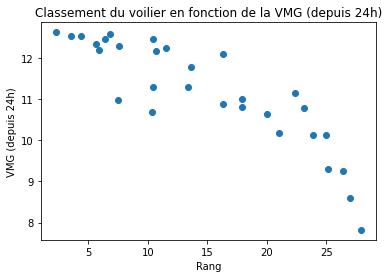

In [253]:
plt.figure()
plt.scatter(df01['rang'], df01['vmg_24h'])
plt.title('Classement du voilier en fonction de la VMG (dernières 24h)')
plt.xlabel('Rang')
plt.ylabel('VMG (dernières 24h)')
plt.show()

On peut déjà commencer à observer une certaine corrélation entre ces deux features : plus la VMG du voilier est élevée, meilleur est son classement.

Rang = -5.468629730735456.VMG + 75.765309248481


[Text(0.5, 1.0, 'Regression linéaire entre le classement et la vmg')]

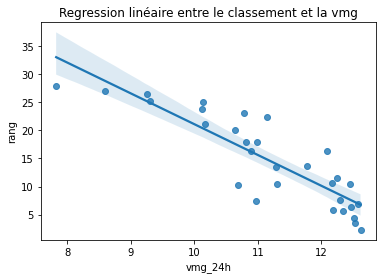

In [21]:
linmod_reg = linear_model.LinearRegression()
X = df01['vmg_24h'].values.reshape(-1, 1)
y = df01['rang'].values.reshape(-1 ,1)
linmod_reg.fit(X, y)

coef = linmod_reg.coef_[0]
inter = linmod_reg.intercept_
print(f"Rang = {coef[0]}.VMG + {inter[0]}")

sns.regplot(data=df01, x='vmg_24h', y='rang').set(title='Regression linéaire entre le classement et la vmg')

### Impact de la présence d'un foil sur le classement et la vitesse des voiliers

In [22]:
df02 = df_all[['no_voile', 'rang', 'nb_derives', 'vitesse_24h']].groupby(['nb_derives']).mean(['rang', 'vitesse_24h'])
df02

,rang,vitesse_24h
nb_derives,,
2,17.306891,11.754599
foils,12.804568,12.849218


In [23]:
print('différence de vitesse moyenne en km/h :', df02['vitesse_24h'][1]*1.85-df02['vitesse_24h'][0]*1.85)
print('différence de classement moyen :', df02['rang'][0]-df02['rang'][1])

différence de vitesse moyenne en km/h : 2.0250449872463037
différence de classement moyen : 4.502323275794305


<Figure size 432x288 with 0 Axes>

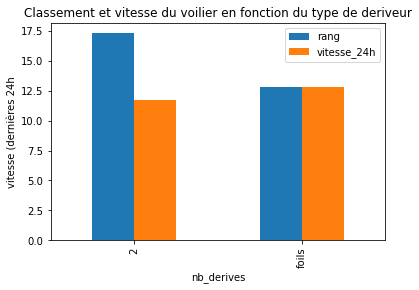

In [24]:
plt.figure()
fig, ax = plt.subplots(1, 1)
df02.plot.bar(ax=ax)
plt.title('Classement et vitesse du voilier en fonction du type de deriveur')
plt.ylabel('vitesse (dernières 24h')
plt.show()

On remarque que les voiliers avec foils vont légèrement plus vite que ceux qui naviguent sans (2km/h de différences). Même si cette différence semble minime, elle pourrait peut-être avoir une influence sur le classement du voilier. En effet, on remarque les voiliers avec un dériveur de type foil ont une différence de classement d'environ 4 places en faveur du voilier avec foil.

### Impact du poids sur le classement et la vitesse des voiliers

In [25]:
df03 = df_all[['no_voile', 'rang', 'poids', 'vitesse_24h']].groupby(['poids']).mean(['rang', 'vitesse_24h'])
df03

,rang,vitesse_24h
poids,,
7.0,26.965000,9.860500
7.6,6.824742,13.763505
7.7,11.499668,12.947774
7.8,14.824074,13.107562
7.9,17.873444,11.911411
8.0,9.923458,13.263042
8.5,21.066432,11.139824
8.9,19.989691,11.670309
9.0,19.854983,11.230241


<Figure size 432x288 with 0 Axes>

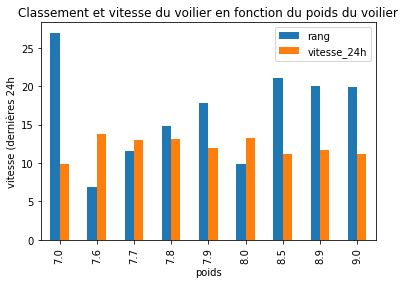

In [26]:
plt.figure()
fig, ax = plt.subplots(1, 1)
df03.plot.bar(ax=ax)
plt.title('Classement et vitesse du voilier en fonction du poids du voilier')
plt.ylabel('vitesse (dernières 24h')
plt.show()

Le poids ne semble pas avoir de réelles influences  sur la vitesse. Malgé cela, on constate tout de même une amélioration du classement lorsque le poids du voilier se rapproche des 7.6 tonnes. Le bateau le plus léger (7 tonnes) n'a pas eu un bon classement. Le poids optimal serait peut-être aux alentours de 7.6t, offrant au voilier un bon compromis entre stabilité et manoeuvrabilité.

### Impact du matérieau de la quille sur le classement et la vitesse des voiliers

In [27]:
df04 = df_all[['no_voile', 'rang', 'voile_quille', 'vitesse_24h']].groupby(['voile_quille']).mean(['rang', 'vitesse_24h'])
df04

,rang,vitesse_24h
voile_quille,,
Inox usiné,10.398734,13.120886
acier,15.387539,12.202347
acier forgé,12.269878,12.826833
basculante vérin,19.457084,11.641986
carbone,20.089691,11.402268
monotype,20.544526,11.284234


<Figure size 432x288 with 0 Axes>

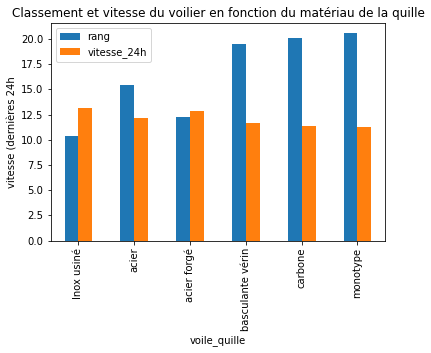

In [28]:
plt.figure()
fig, ax = plt.subplots(1, 1)
df04.plot.bar(ax=ax)
plt.title('Classement et vitesse du voilier en fonction du matériau de la quille')
plt.ylabel('vitesse (dernières 24h')
plt.show()

On remarque que l'inox usiné offre de bons résultats : il devance les autres matériaux en terme de classement et de vitesse. Cependant, les voiliers en inox usiné ne représentent qu'une petite partie de notre échantillon de voilier, les matériaux majoritaires étant l'acier et l'acier forgé. En comparant ces deux derniers, on constate que les voiliers avec une quille en acier forgé ont en moyenne un meilleur classement et une vitesse plus élevée.

### Visualisation de la distance parcourue par voilier.

In [29]:
df05 = df_all[['no_voile', 'dist_24h']].groupby(['no_voile']).sum(['dist_24h'])
df05 = df05.merge(df_all[['no_voile','rang']].groupby(['no_voile']).mean(['rang']), how='inner', on='no_voile')
df05 = df05[['rang', 'dist_24h']].sort_values('rang', ascending=True)
df05

,rang,dist_24h
no_voile,,
79,2.283058,160838.7
59,3.515464,160523.3
17,4.356701,158628.2
1,5.595876,154868.0
85,5.846715,44855.4
1000,6.371134,155320.6
18,6.824742,160234.0
99,7.461538,47493.1
9,7.538144,155376.3


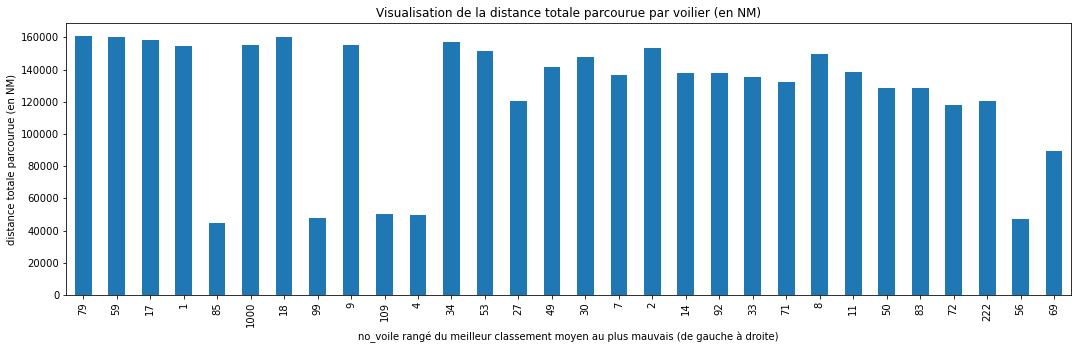

In [30]:
plt.figure(figsize=(18, 5))
df05['dist_24h'].plot(title = 'Visualisation de la distance totale parcourue par voilier (en NM)', kind = 'bar')
plt.xlabel('no_voile rangé du meilleur classement moyen au plus mauvais (de gauche à droite)')
plt.ylabel('distance totale parcourue (en NM)')
plt.show()

On remarque que plus les voiliers ont un bon classement moyen, plus leur distance totale parcourue est grande.

### Cartes avec les routes d'un ou plusieurs voiliers

In [31]:
# pip install folium
import folium

In [32]:
#transformer latitude et longitude en valeur numérique

# conversion degrés, minutes, secondes => décimal
def dms2dec(deg, mn, sec):
    dd = deg + (mn/60) + (sec/3600)
    return dd

df_all['latitude'] = df_all['latitude'].apply(lambda x : float(dms2dec(float(x.split("°")[0]), float(x.split("°")[1].split(".")[0]), float(x.split("°")[1].split(".")[1].split("'")[0]))) if isinstance(x, str) else x)
df_all['longitude'] = df_all['longitude'].apply(lambda x : float(dms2dec(float(x.split("°")[0]), float(x.split("°")[1].split(".")[0]), float(x.split("°")[1].split(".")[1].split("'")[0]))) if isinstance(x, str) else x)

In [33]:
df_79_traj = df_all[df_all['no_voile']=='79']
df_79_traj = df_79_traj[['date', 'no_voile', 'latitude', 'longitude']]
df_79_traj

,date,no_voile,latitude,longitude
11848,2020-11-08 15:00:00,79,46.296111,2.529167
11849,2020-11-08 17:00:00,79,46.275556,3.377500
11850,2020-11-08 21:00:00,79,46.175833,4.795000
11851,2020-11-09 04:00:00,79,46.603056,7.245000
11852,2020-11-09 08:00:00,79,46.916111,8.278056
...,...,...,...,...
12327,2021-01-26 21:00:00,79,43.950556,8.923056
12328,2021-01-27 04:00:00,79,43.896111,6.758333
12329,2021-01-27 08:00:00,79,44.753333,5.433611
12330,2021-01-27 11:00:00,79,45.476389,4.523889


In [34]:
map = folium.Map()
for lat, long in zip(df_79_traj['latitude'], df_79_traj['longitude']): 
    folium.Marker(location=[lat, long].add_to(map))
map

AttributeError: 'list' object has no attribute 'add_to'

In [35]:
map = folium.Map()
folium.Marker(location=[df_all['latitude'][0], df_all['longitude'][0]]).add_to(map)
map
